# 📘 04_logistics_vs_satisfaction

Proyecto: Análisis del desempeño logístico y satisfacción del cliente en ecommerce (México) <br>
Versión: v1

# Análisis de la relación entre logística y satisfacción del cliente

En este notebook se explora cómo se relacionan dos aspectos clave del ecommerce:
el comportamiento de las entregas y la satisfacción del cliente reflejada en las calificaciones (review_score).

El propósito es observar si existen patrones que sugieran que los tiempos de entrega, los retrasos o la consistencia en el proceso logístico influyen, aunque sea de forma general, en la valoración que hacen los usuarios de su experiencia de compra.

En particular, este análisis se enfoca en:

- Comparar tiempos de entrega con las calificaciones otorgadas.
- Revisar si los retrasos (o entregas anticipadas) tienen algún efecto visible en la puntuación del cliente.
- Identificar tendencias generales o comportamientos atípicos que puedan ser útiles para interpretaciones posteriores.
- Visualizar estas relaciones mediante gráficos sencillos para obtener una primera lectura del panorama.

Este cuaderno no pretende construir modelos predictivos, sino explorar si existe alguna relación observable entre el desempeño operativo del ecommerce y la percepción del usuario final.
Los resultados servirán como base para interpretaciones más amplias en la fase de conclusiones y en el notebook final de síntesis.

In [9]:
# Carga de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML


# Carga de datasets

path = "https://raw.githubusercontent.com/RaquelGlez/ecommerce_report/refs/heads/main/data/processed/"

orders = pd.read_csv(path + 'orders_enriched.csv')
customers = pd.read_csv(path + 'customers_clean.csv')

# Vista rápida del contenido
print(f"Orders: {orders.shape} | Customers: {customers.shape}")

# Vista inicial
orders.head()


Orders: (3000, 16) | Customers: (3000, 5)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delay_vs_estimate,is_late,purchase_day,purchase_month,week_of_year,order_total_value,review_score
0,ord_7370c26ead3d3cc6cee4f0548b8d,cus_3b0234601c0276e6cd4e08b6ae67,shipped,2025-08-16 21:12:27.948040,2025-08-16 23:12:27.948040,2025-08-17 23:12:27.948040,NaN,2025-08-24 23:12:27.948040,NaN,NaN,NaN,Saturday,August,33,4949.98,3
1,ord_079072dd7970d40a3922a6b0c459,cus_24cb3fa4569c4fd058f954f2e6f9,delivered,2024-12-12 02:52:21.349382,2024-12-12 05:52:21.349382,2024-12-14 05:52:21.349382,2024-12-15 05:52:21.349382,2024-12-15 05:52:21.349382,3.0,0.0,0.0,Thursday,December,50,1276.09,4
2,ord_2600b1cb6f6a38610007a8c9142c,cus_67a2c2db5bd7dc2f06a8f9b40226,delivered,2025-06-13 03:04:55.053859,2025-06-13 19:04:55.053859,2025-06-16 19:04:55.053859,2025-06-21 19:04:55.053859,2025-06-21 19:04:55.053859,8.0,0.0,0.0,Friday,June,24,2137.68,4
3,ord_aaa7c4626ea7ea636e5bba7afebd,cus_2b70a9c550bfd5e065a756e9fe9b,delivered,2025-04-26 01:55:37.919760,2025-04-26 08:55:37.919760,2025-04-27 08:55:37.919760,2025-04-28 08:55:37.919760,2025-04-29 08:55:37.919760,2.0,-1.0,0.0,Saturday,April,17,989.99,3
4,ord_0ca0641b834ceb0a46f85637e125,cus_36ba5c7d572c22a6650f11e37f4d,delivered,2025-06-21 18:52:40.013157,2025-06-21 21:52:40.013157,2025-06-22 21:52:40.013157,2025-06-25 21:52:40.013157,2025-06-27 21:52:40.013157,4.0,-2.0,0.0,Saturday,June,25,4403.75,3


En este paso se cargan las tablas procesadas desde Google Drive, incluyendo el dataset enriquecido de pedidos. Esta versión ya contiene las columnas derivadas que se usarán para el análisis, como delivery_time_days, delay_vs_estimate, order_total_value y review_score, además de la información básica del cliente. Con esta estructura lista, se puede avanzar directamente al estudio de cómo los tiempos de entrega se relacionan con la satisfacción.

## Análisis descriptivo
En esta parte realizamos un análisis descriptivo inicial para entender cómo se distribuyen las calificaciones de los clientes y cómo se comportan los indicadores logísticos básicos asociados a ellas. El objetivo es obtener una primera impresión sobre posibles tendencias antes de avanzar hacia visualizaciones o análisis más profundos.

In [10]:
# Distribución general del review_score

orders['review_score'].describe()
orders['review_score'].value_counts(normalize=True).sort_index()


# Promedios logísticos por nivel de satisfacción
summary = orders.groupby('review_score')[['delivery_time_days', 'delay_vs_estimate']].mean().reset_index()
summary


,review_score,delivery_time_days,delay_vs_estimate
0,1,5.125984,-1.511811
1,2,5.146739,-1.543478
2,3,5.069378,-1.490431
3,4,4.990033,-1.488372
4,5,5.091398,-1.456989


El resumen generado muestra, para cada nivel de calificación, el tiempo promedio de entrega y la diferencia promedio respecto a la fecha estimada. Esta información ayuda a observar si existe un patrón simple: por ejemplo, si las calificaciones bajas están asociadas con mayores retrasos o tiempos de entrega más largos. Aunque es un análisis exploratorio, sirve como punto de partida para detectar señales tempranas de relación entre logística y satisfacción.

In [11]:
orders['review_score'].value_counts()

,count
review_score,
5,1072
4,886
3,595
2,278
1,169


## Visualización de relaciones clave
En esta sección se visualizan relaciones clave entre los tiempos de entrega y la satisfacción del cliente. El objetivo es identificar si existen patrones visibles que sugieran que ciertos niveles de calificación están asociados con tiempos de entrega más largos o más cortos.

### Tiempo de entrega vs calificación

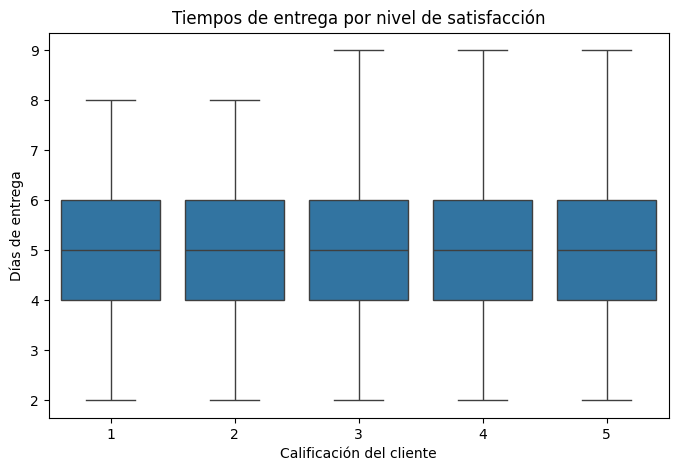

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x='review_score', y='delivery_time_days', data=orders)
plt.title("Tiempos de entrega por nivel de satisfacción")
plt.xlabel("Calificación del cliente")
plt.ylabel("Días de entrega")
plt.show()




El boxplot permite comparar de forma directa la distribución de los días de entrega entre los distintos niveles de calificación. En general, los tiempos de entrega se mantienen bastante similares en todos los grupos, con medianas que prácticamente no cambian y rangos muy parecidos. Esto sugiere que el tiempo de entrega no muestra variaciones relevantes entre clientes con diferentes calificaciones, por lo que no parece ser un factor determinante en la puntuación otorgada.

### Retraso vs calificación
En esta sección se examina si la diferencia entre la fecha real de entrega y la estimación inicial varía según la calificación del cliente. Esto permite identificar si los usuarios que otorgan puntuaciones más bajas experimentan retrasos más notorios o si el comportamiento logístico es similar entre todos los grupos.

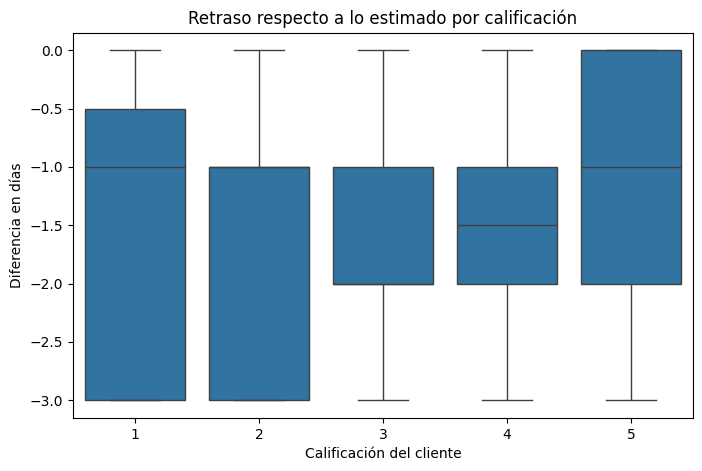

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x='review_score', y='delay_vs_estimate', data=orders)
plt.title("Retraso respecto a lo estimado por calificación")
plt.xlabel("Calificación del cliente")
plt.ylabel("Diferencia en días")
plt.show()




El boxplot muestra que, en general, la diferencia entre la fecha real y la estimada suele ser negativa para todos los niveles de calificación, lo que indica que los pedidos tienden a llegar antes de lo previsto. Aunque hay variabilidad, no se observan cambios marcados entre los distintos niveles de review_score: incluso los clientes que califican con puntuaciones bajas recibieron sus pedidos con adelanto similar al resto. Esto sugiere que el retraso (o adelanto) respecto a lo estimado no parece ser un factor determinante en la satisfacción.

### Porcentaje de pedidos con retraso según calificación
En esta parte analizamos qué tan frecuente es que los pedidos lleguen con retraso según la calificación otorgada por el cliente. La idea es identificar si existe un patrón que relacione la satisfacción con la puntualidad de la entrega.

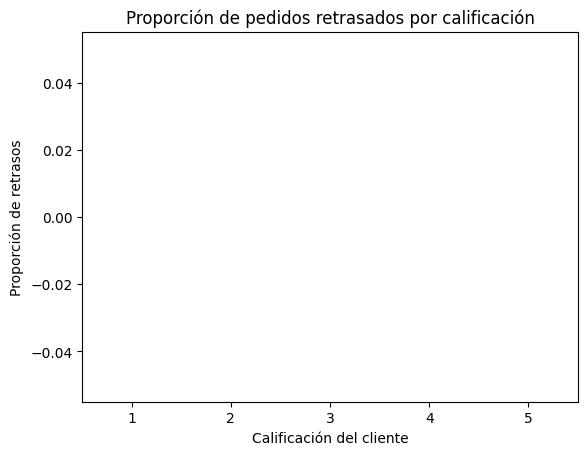

In [14]:
delay_by_score = orders.groupby('review_score')['is_late'].mean().reset_index()
sns.barplot(x='review_score', y='is_late', data=delay_by_score)
plt.title("Proporción de pedidos retrasados por calificación")
plt.xlabel("Calificación del cliente")
plt.ylabel("Proporción de retrasos")
plt.show()

En este caso, el gráfico no muestra una relación clara entre la proporción de pedidos con retraso y la calificación del cliente.
Esto se debe a que la variable is_late presenta muy poca variabilidad dentro del dataset: la mayoría de los pedidos fueron entregados a tiempo o antes de la fecha estimada, independientemente del nivel de calificación.

La ausencia de diferencias visibles entre las calificaciones indica que, en este conjunto de datos, los retrasos no son un factor determinante para explicar la satisfacción del cliente. Esto sugiere que otros elementos, no analizados en esta sección, podrían tener un peso mayor en la percepción del servicio.

Este resultado es igualmente valioso, ya que permite descartar una relación directa fuerte entre ambas variables y orienta el análisis hacia otras dimensiones del proceso de compra.

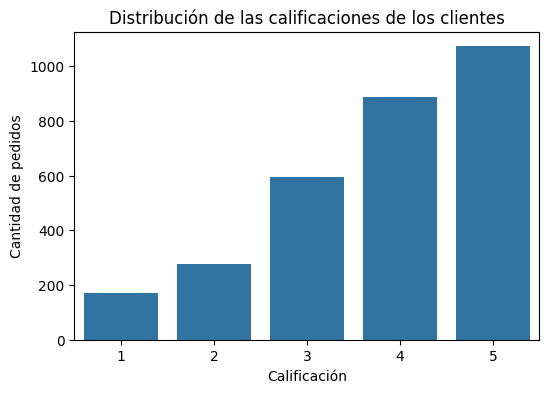

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x='review_score', data=orders)
plt.title("Distribución de las calificaciones de los clientes")
plt.xlabel("Calificación")
plt.ylabel("Cantidad de pedidos")
plt.show()

La distribución de calificaciones muestra una clara concentración en valores altos, lo que indica que la mayoría de los clientes evalúan positivamente su experiencia. Las calificaciones bajas representan una proporción menor del total de pedidos.

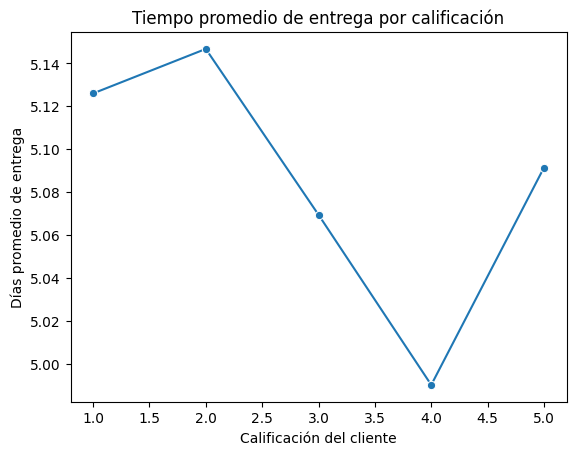

In [16]:
avg_delivery = orders.groupby('review_score')['delivery_time_days'].mean().reset_index()

sns.lineplot(x='review_score', y='delivery_time_days', data=avg_delivery, marker='o')
plt.title("Tiempo promedio de entrega por calificación")
plt.xlabel("Calificación del cliente")
plt.ylabel("Días promedio de entrega")
plt.show()

El tiempo promedio de entrega se mantiene relativamente estable entre los distintos niveles de calificación.
Las diferencias observadas son pequeñas y no muestran un patrón claro que indique que entregas más rápidas se traduzcan directamente en mejores evaluaciones.
Esto sugiere que la satisfacción del cliente no depende únicamente de la duración total del envío, sino probablemente de otros factores, como el cumplimiento de la fecha prometida o la experiencia general del proceso.

## Conclusiones

Los resultados muestran que, dentro de este dataset, los tiempos de entrega se mantienen relativamente estables entre los distintos niveles de calificación. No se observa un patrón claro que indique que entregas más rápidas se traduzcan directamente en mejores evaluaciones por parte de los clientes.

De forma similar, la diferencia entre la fecha real y la fecha estimada de entrega no presenta variaciones relevantes según la calificación otorgada. En promedio, los pedidos tienden a llegar ligeramente antes de lo previsto, independientemente del nivel de satisfacción.

La proporción de pedidos con retraso tampoco muestra diferencias entre grupos, lo cual es consistente con la naturaleza del dataset y sugiere una experiencia de entrega bastante homogénea.

En conjunto, este análisis indica que, bajo las variables consideradas, la logística por sí sola no explica las variaciones en la satisfacción del cliente. Factores adicionales, como expectativas, características del producto o comunicación, probablemente juegan un papel importante.
